### IMPORT

In [ ]:
import pandas as pd
import re

### CHECK AND PREPARE DATA

In [ ]:
# train_df = pd.read_csv('/content/train.csv')
# dev_df = pd.read_csv('/content/dev.csv')
data = pd.read_csv('/content/all.csv')

In [ ]:
from sklearn.model_selection import train_test_split

train_df, dev_df = train_test_split(data, train_size=0.8, random_state=77)
# dev_df, test_df = train_test_split(dev_test, test_size=0.5, random_state=77)

labels = list(set(data['label'].to_list()))
label_to_idx = {label:i for i,label in enumerate(labels)}
label_list = [0] * len(labels)

label_list = [0] * len(label_to_idx)
for label in label_to_idx:
  label_list[label_to_idx[label]] = label 

train_df['label'] = train_df['label'].apply(lambda x: label_to_idx[x])
dev_df['label'] = dev_df['label'].apply(lambda x: label_to_idx[x])
# test_df['label'] = test_df['label'].apply(lambda x: label_to_idx[x])

# Transformer

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 29 09:21:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P8    14W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import (
    AutoTokenizer, 
    AutoModel,
    AutoModelForSequenceClassification, 
    AutoConfig,

    Trainer, 
    TrainingArguments,
)

from datasets import (
    Dataset,
    DatasetDict,
    Features, Sequence, ClassLabel, Value
)

In [ ]:
model_name = 'airesearch/wangchanberta-base-att-spm-uncased'
config = AutoConfig.from_pretrained(model_name, num_labels=len(labels))
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                           config=config)



Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wa

# Use Dataset Module

In [ ]:
train_dict = train_df.to_dict('series')
dev_dict = dev_df.to_dict('series')
# test_dict = test_df.to_dict('series')

In [ ]:
features= Features({
                    #"title tokens": Sequence(Value(dtype='string')),
                    "text": Value(dtype='string'),
                    
                    "label": ClassLabel(names=label_list)
                })
d = DatasetDict({'train': Dataset.from_dict(train_dict, features=features), 
                 'dev': Dataset.from_dict(dev_dict, features=features)})

In [ ]:
d

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 300
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 75
    })
})

In [ ]:
d['train'][0]

{'text': '2525/581ย่อสั้นจำเลยเป็นธนาคารละเลยไม่เรียกเก็บเงินตามเช็คให้โจทก์ซึ่งเป็นลูกค้าทั้งๆที่เงินในบัญชีของผู้สั่งจ่ายเช็คนั้นมีพอที่จะหักเข้าบัญชีให้โจทก์ได้ก่อนและบัญชีของผู้สั่งจ่ายก็อยู่ในธนาคารจำเลยเองเป็นเหตุให้เงินในบัญชีของผู้สั่งจ่ายกลับไม่พอชำระหนี้ตามเช็คให้โจทก์เพราะได้มีการถอนเงินรายอื่นหลายรายการจากบัญชีของผู้สั่งจ่ายในวันนั้นและจำเลยก็มิได้แจ้งเหตุขัดข้องและคืนเช็คให้โจทก์จำเลยจึงต้องรับผิดย่อยาวโจทก์ฟ้องว่าจำเลยที่1เป็นธนาคารจำเลยที่2เป็นลูกจ้างจำเลยที่1ทำหน้าที่สมุห์บัญชีธนาคารจำเลยที่1สาขาพิษณุโลกโจทก์เป็นลูกค้าของจำเลยที่1ได้เปิดบัญชีเงินฝากกระแสรายวันที่ธนาคารจำเลยที่1สาขาพิษณุโลกเมื่อวันที่31ตุลาคม2520โจทก์นำเช็คธนาคารจำเลยที่1สาขาพิษณุโลกเลขที่011399/2333ลงวันที่1พฤศจิกายน2520จำนวนเงิน100,000บาทซึ่งนายวิรัชจิรัฐติกาลโชติสั่งจ่ายชำระหนี้ให้โจทก์ไปฝากเข้าบัญชีของโจทก์เพื่อเรียกเก็บเงินจำเลยที่2เป็นผู้รับเช็คดังกล่าวไว้โจทก์เข้าใจว่าธนาคารจำเลยที่1ได้เรียกเก็บเงินให้โจทก์เรียบร้อยแล้วต่อมาเมื่อเดือนมิถุนายน2521โจทก์ได้ตรวจสอบบัญชีของโจทก์พบว่าจำเลยที่1และจำเลยที

# Tokenize

In [ ]:
def tokenize(examples):
    tokenized_inputs = tokenizer(examples["text"], 
                                 is_split_into_words=False,
                                 truncation=True,
                                 max_length=256)
    return tokenized_inputs
tokenized_datasets = d.map(tokenize, batched=True)


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenizer.convert_ids_to_tokens(tokenized_datasets['train'][0]['input_ids'])

['<s>',
 '▁',
 '2525',
 '/5',
 '81',
 'ย่อ',
 'สั้น',
 'จําเลย',
 'เป็น',
 'ธนาคาร',
 'ละเลย',
 'ไม่',
 'เรียก',
 'เก็บเงิน',
 'ตาม',
 'เช็ค',
 'ให้',
 'โจทก์',
 'ซึ่งเป็น',
 'ลูกค้า',
 'ทั้งๆที่',
 'เงิน',
 'ในบัญชี',
 'ของผู้',
 'สั่ง',
 'จ่าย',
 'เช็ค',
 'นั้นมี',
 'พอที่จะ',
 'หัก',
 'เข้าบัญชี',
 'ให้',
 'โจทก์',
 'ได้',
 'ก่อน',
 'และ',
 'บัญชี',
 'ของผู้',
 'สั่ง',
 'จ่าย',
 'ก็',
 'อยู่ใน',
 'ธนาคาร',
 'จําเลย',
 'เอง',
 'เป็นเหตุ',
 'ให้เงิน',
 'ในบัญชี',
 'ของผู้',
 '</s>']

# Prepare Model

In [ ]:
model_name.split('/')[-1]

'wangchanberta-base-att-spm-uncased'

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer,
                                        padding=True, pad_to_multiple_of=8)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
#tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
#tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['label', 'input_ids', 'attention_mask']

In [ ]:
tokenized_datasets['dev'][20]

{'label': 0,
 'input_ids': [5,
  10,
  12720,
  4554,
  790,
  4283,
  1886,
  3897,
  33,
  2052,
  10545,
  24988,
  1429,
  7653,
  6971,
  10861,
  12,
  3685,
  30,
  1171,
  1191,
  12319,
  2052,
  1644,
  3548,
  100,
  3897,
  3897,
  5050,
  1496,
  1809,
  657,
  267,
  3314,
  335,
  3645,
  32,
  2052,
  15,
  4283,
  623,
  3897,
  1809,
  27,
  2052,
  16153,
  23138,
  1575,
  1429,
  6],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [ ]:
samples = tokenized_datasets["train"][:8]
samples = {k: v for k, v in samples.items()}
[len(x) for x in samples["input_ids"]]

[50, 50, 50, 25, 50, 50, 50, 50]

In [ ]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

You're using a CamembertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': torch.Size([8, 56]),
 'attention_mask': torch.Size([8, 56]),
 'labels': torch.Size([8])}

In [ ]:
from datasets import list_metrics, load_metric
list_metrics()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: list_metrics is deprecated and will be removed in the next major version of datasets. Use 'evaluate.list_evaluation_modules' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


['accuracy',
 'bertscore',
 'bleu',
 'bleurt',
 'brier_score',
 'cer',
 'chrf',
 'code_eval',
 'comet',
 'competition_math',
 'coval',
 'cuad',
 'exact_match',
 'f1',
 'frugalscore',
 'glue',
 'google_bleu',
 'indic_glue',
 'mae',
 'mahalanobis',
 'mape',
 'mase',
 'matthews_correlation',
 'mauve',
 'mean_iou',
 'meteor',
 'mse',
 'pearsonr',
 'perplexity',
 'poseval',
 'precision',
 'recall',
 'rl_reliability',
 'roc_auc',
 'rouge',
 'sacrebleu',
 'sari',
 'seqeval',
 'smape',
 'spearmanr',
 'squad',
 'squad_v2',
 'super_glue',
 'ter',
 'trec_eval',
 'wer',
 'wiki_split',
 'xnli',
 'xtreme_s',
 'Drunper/metrica_tesi',
 'Felipehonorato/my_metric',
 'GMFTBY/dailydialog_evaluate',
 'GMFTBY/dailydialogevaluate',
 'JP-SystemsX/nDCG',
 'KevinSpaghetti/accuracyk',
 'NCSOFT/harim_plus',
 'NikitaMartynov/spell-check-metric',
 'NimaBoscarino/weat',
 'Ochiroo/rouge_mn',
 'Vertaix/vendiscore',
 'Viona/infolm',
 'Vlasta/pr_auc',
 'abdusah/aradiawer',
 'abidlabs/mean_iou',
 'abidlabs/mean_iou2',
 '

In [ ]:
load_metric('accuracy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  """Entry point for launching an IPython kernel.


Metric(name: "accuracy", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    normalize (`boolean`): If set to False, returns the number of correctly classified samples. Otherwise, returns the fraction of correctly classified samples. Defaults to True.
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    accuracy (`float` or `int`): Accuracy score. Minimum possible value is 0. Maximum possible value is 1.0, or the number of examples input, if `normalize` is set to `True`.. A higher score means higher accuracy.

Examples:

    Example 1-A simple example
        >>> accuracy_metric = datasets.load_metric("accuracy")
        >>> results = accuracy_metric.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0])
        >>> print(results)
        {'accuracy': 0.5}

   

# Training a.k.a. babysitting

In [ ]:
args = TrainingArguments(
    output_dir='nlp_III'
)

args2 = TrainingArguments(
    output_dir='nlp_law',
    learning_rate=3e-5,
    per_device_train_batch_size=96,
    per_device_eval_batch_size=96,
    num_train_epochs=90,
    # load_best_model_at_end=True,
    # metric_for_best_model='accuracy',
    # evaluation_strategy='steps', 
    # eval_steps=2,
    #save_strategy='epoch'    
)
#metric.compute(predictions=preds, references=predictions.label_ids)
import numpy as np

def compute_metrics(eval_preds):
  metric = load_metric("accuracy")
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model,
    args2,
    train_dataset=tokenized_datasets["train"],
    # eval_dataset=tokenized_datasets["dev"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 300
  Num Epochs = 90
  Instantaneous batch size per device = 96
  Total train batch size (w. parallel, distributed & accumulation) = 96
  Gradient Accumulation steps = 1
  Total optimization steps = 360
  Number of trainable parameters = 105247492


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=360, training_loss=0.2834252251519097, metrics={'train_runtime': 260.0713, 'train_samples_per_second': 103.818, 'train_steps_per_second': 1.384, 'total_flos': 777013788096000.0, 'train_loss': 0.2834252251519097, 'epoch': 90.0})

In [ ]:
predictions = trainer.predict(tokenized_datasets['dev'])
preds = np.argmax(predictions.predictions, axis=-1)


***** Running Prediction *****
  Num examples = 75
  Batch size = 96


In [ ]:
predictions

PredictionOutput(predictions=array([[-2.992997  , -0.96178794, -1.6672978 ,  5.433237  ],
       [-3.3667786 , -1.4892448 , -0.84481514,  5.4702134 ],
       [-2.6109064 ,  4.927654  , -1.5070606 , -1.3372573 ],
       [-2.1174135 , -1.8084865 , -1.1346183 ,  5.559157  ],
       [ 5.760464  , -2.4777722 , -1.821674  , -2.260896  ],
       [ 3.2688663 , -1.678241  , -2.9831991 ,  0.9870791 ],
       [ 5.706802  , -3.0012054 , -1.2729127 , -2.2479737 ],
       [-2.1941319 , -1.7608334 , -1.5345688 ,  5.476687  ],
       [ 5.489679  , -2.969306  , -0.6140075 , -2.5093002 ],
       [-1.4849871 , -1.5021783 , -2.6306133 ,  5.4657946 ],
       [-2.9556992 ,  5.0055437 , -0.70868546, -1.4841292 ],
       [ 5.4814515 , -2.4891274 , -0.75967157, -2.9492989 ],
       [-2.4541862 ,  5.0896373 , -1.5677617 , -1.5119424 ],
       [-1.2031412 ,  3.7686882 , -1.8628564 , -1.7298275 ],
       [ 5.4749084 , -1.9896944 , -1.7841341 , -2.4229126 ],
       [-0.6449286 , -1.6975801 ,  4.7264824 , -2.667518

In [ ]:
predictions.label_ids

array([1, 3, 1, 3, 0, 0, 0, 3, 0, 3, 1, 0, 1, 2, 0, 2, 0, 2, 2, 3, 0, 0,
       3, 2, 3, 0, 3, 2, 0, 0, 3, 2, 2, 1, 2, 0, 3, 1, 0, 3, 3, 0, 0, 3,
       0, 0, 0, 1, 1, 3, 0, 0, 3, 2, 2, 2, 0, 1, 3, 2, 1, 3, 0, 3, 0, 3,
       3, 0, 0, 3, 3, 3, 1, 3, 3])

In [ ]:
preds

array([3, 3, 1, 3, 0, 0, 0, 3, 0, 3, 1, 0, 1, 1, 0, 2, 0, 0, 2, 3, 1, 1,
       3, 1, 3, 1, 3, 2, 0, 0, 1, 0, 0, 1, 2, 0, 3, 3, 0, 3, 3, 2, 0, 3,
       0, 0, 0, 1, 1, 1, 0, 3, 3, 1, 2, 2, 0, 1, 3, 2, 1, 3, 0, 3, 0, 3,
       3, 0, 0, 3, 1, 3, 1, 3, 2])

In [ ]:
predicted_labels = [labels[x] for x in preds]
gold = [labels[x] for x in predictions.label_ids]

# Evaluation No.1 (no fine tune)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(gold, predicted_labels))

                     precision    recall  f1-score   support

          favorable       0.50      0.82      0.62        11
              other       0.78      0.54      0.64        13
partially favorable       0.88      0.84      0.86        25
        unfavorable       0.88      0.81      0.84        26

           accuracy                           0.77        75
          macro avg       0.76      0.75      0.74        75
       weighted avg       0.80      0.77      0.78        75



In [ ]:
### reset model
# Trainer = 0

In [ ]:
# from google.colab import files

# files.download('/content/wongnai-review-2')

In [ ]:
# !zip -r /content/wongnai-review-2.zip /content/wongnai-review-2

In [ ]:
# from google.colab import files
# files.download("/content/wongnai-review-2.zip")

# STAT
- learning_rate=3e-5
- per_device_train_batch_size=96
- per_device_eval_batch_size=96
- num_train_epochs=60

+ epoch 20 อีกรอบ

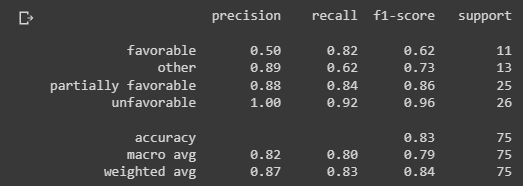

# 60 epoch แท้

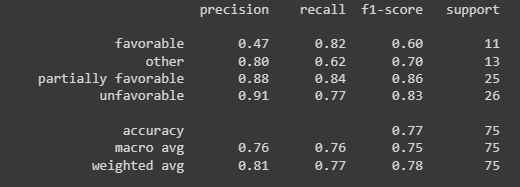

# 80 Epoch
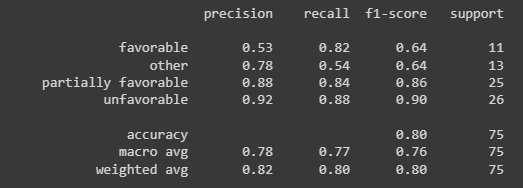